# Detección de anomalías

### 1-. Carga de datos

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import DistanceMetric
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, calinski_harabaz_score, davies_bouldin_score

from pyod.models.iforest import IForest

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import dates
import seaborn as sns

import warnings

# filter warnings 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# load data
df = pd.read_csv("bikes.csv", index_col=0, parse_dates=True)

La serie es una serie temporal de granularidad horaria. Cada observación es un agregado de demanda de todas las estaciones de bike-sharing de Barcelona. El intervalo de la muestra va desde principios de noviembre de 2018 hasta finales de 2018. Se pueden descargar los datos [aquí](http://opendata-ajuntament.barcelona.cat/data/es/dataset/bicing)

### 2-. EDA

Como todo problema de ciencia de datos, tiene que haber una fase de análisis exploratorio. Con esto, intentaremos responder a las preguntas de:
 - ¿De qué naturaleza son mis datos?
 - ¿Qué primeras conclusiones podemos extraer?

Queremos encontrar anomalías dentro de nuestra variable:

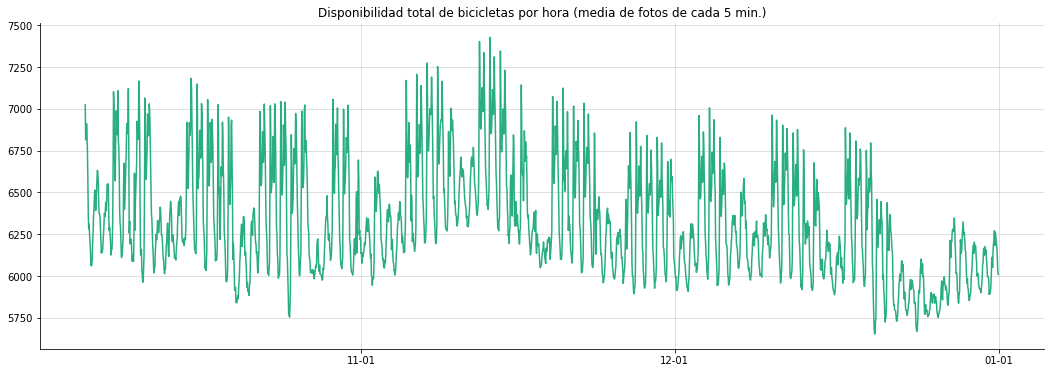

In [2]:
fig = plt.figure(figsize=(18, 6))
ax = plt.axes()
days = dates.MonthLocator()
myFmt = DateFormatter("%m-%d") 
plt.grid(alpha=0.5)
ax.plot(df, c='#29AF7FFF')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(myFmt) 
ax.set_title('Disponibilidad total de bicicletas por hora (media de fotos de cada 5 min.)')
sns.despine(left=False, bottom=False)

Al tratarse de una serie temporal, ya vemos que hay marcadas características de una serie temporal, como son la estacionalidad y al tendencia. Más en concreto, visualizando la estacionalidad, vemos que hay determinadas horas en las que hay más demanda de bicicletas que en otras. En concreto, en los primeros días de la semana, y a las 8 de la mañana y a las 6 de la tarde, es cuando más demanda hay, mientras que es en los fines de semana cuando vemos menos demanda.

Text(0.5, 1.0, 'Estacionalidad')

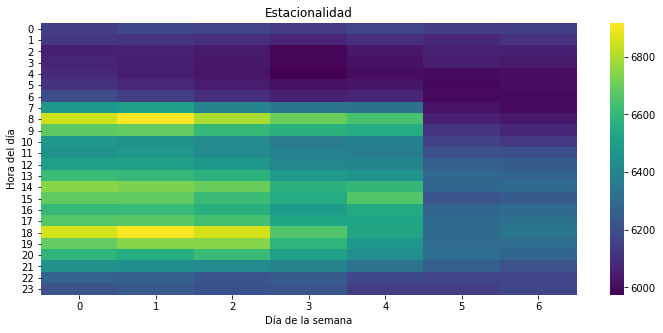

In [3]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
sns.heatmap(df.pivot_table(columns=df.index.weekday, index=df.index.hour, values='y', aggfunc=np.mean), 
            ax=ax, cmap="viridis")
ax.set_xlabel("Día de la semana")
ax.set_ylabel("Hora del día")
ax.set_title("Estacionalidad")

Si inspeccionamos más concretamente las franjas horarias, veremos que apenas hay anomalías:

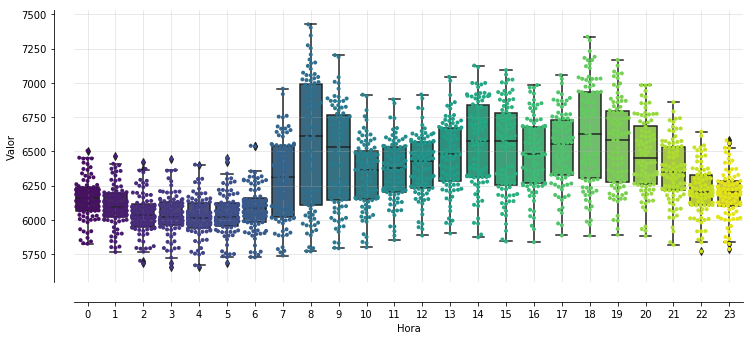

In [4]:
hours = df.index.hour.unique()
aux = list()
for hour in hours:
    xx = df.loc[df.index.hour == hour]
    xx.index = xx.index.date
    aux.append(xx)
aux = pd.concat(aux, 1)
aux.columns = hours
aux = aux.stack().reset_index().rename(index=str, columns={'level_0':'dia', 'ds': 'Hora', 0: 'Valor'})
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
sns.boxplot(x='Hora', y='Valor', data=aux, palette='viridis', ax=ax)
sns.swarmplot(x="Hora", y="Valor", data=aux, palette="viridis", size=4)
ax.grid(alpha=0.35)
sns.despine(offset=20)

Viendo los boxplot de cada franja horaria, apenas hay observaciones que se salgan del mínimo o sean mayores que el máximo. Estos mínimos y máximos vienen dados por:
$$IQx * 1.5$$
donde IQx es el rango intercuartílico inferior o superior.

Por otro lado, viendo las tendencias de la serie, vemos que hay una cierta tendencia negativa.

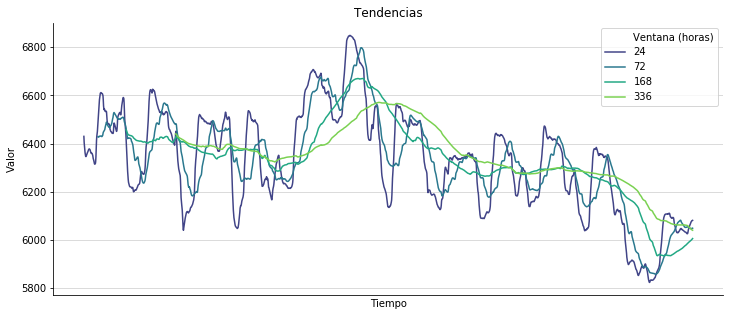

In [5]:
windows = [24, 24 * 3, 24 * 7, 24 * 7 * 2]
rolling_frame = pd.concat([df.rolling(window).mean() for window in windows], axis=1)
rolling_frame.columns = windows
rolling_frame = rolling_frame.stack().reset_index().rename(
    index=str, columns={"ds": "Tiempo", "level_1": "Ventana (horas)", 0: "Valor"})

palette = sns.color_palette("viridis", 4)
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
sns.lineplot(x="Tiempo", y="Valor",
             hue="Ventana (horas)", data=rolling_frame, ax=ax,
            palette=palette)
ax.set_xticks([])
ax.set_title("Tendencias")
sns.despine(left=False, bottom=False)
plt.grid(color='lightgray')

### 3-. Feature Engineering

Una medida robusta para detectar de anomalías suele ser la mediana. Si vamos más allá, podemos utilizar una medida de distancia relacionada con este estimador para tener una visión más amplia de las observaciones en cuanto a desviación y grado anormalidad. Introducimos pues el concepto de _Median Absolute Deviation_, que viene dado de la forma:
$$
MAD = median(|X_i - median(X)|)
$$

Básicamente lo que hace es calcular la distancia de un punto respecto de la mediana de la muestra.

Como hemos visto, existe una marcada estacionalidad en ciertos componentes temporales, como son el **día de la semana** y la **hora** del día. Por tanto, computaremos la MAD de cada observación en cada uno de esos puntos de corte. Por ejemplo, aplicaremos la MAD a cada observación dentro de todas las 9.00 hrs de la mañana, o a todas las observaciones de cada lunes. Añadiremos una tercera _feature_ proveniente de calcular la MAD de las franjas horarias y los días de la semana a la vez, por ejemplo, la MAD de cada observación de la franja de las 9 de mañana de los lunes respecto de esa misma franja.

In [6]:
if_data = df.copy()
if_data['hour'] = if_data.index.hour
if_data['weekday'] = if_data.index.weekday

xx = np.zeros((len(if_data), 3))

# por cada tick horario
for hour in if_data['hour'].unique():

    # los datos
    idx = if_data[if_data['hour'] == hour].index
    aux_df = if_data.loc[idx, 'y']

    # mediana de la muestra
    med = np.median(aux_df.values)
    
    # distancia
    dist = np.abs(aux_df - med)
    
    # colocamos
    xx[np.isin(if_data.index, idx), 0] = dist.values
    
# por cada día de la semana
for day in if_data['weekday'].unique():
    
    # los datos
    idx = if_data[if_data['weekday'] == day].index
    aux_df = if_data.loc[idx, 'y']

    # mediana de la muestra
    med = np.median(aux_df.values)
    
    # distancia
    dist = np.abs(aux_df - med)
    
    # colocamos
    xx[np.isin(if_data.index, idx), 1] = dist.values
    

# por cada día y hora de la semana
for day in if_data['weekday'].unique():
    for hour in if_data['hour'].unique():
        # los datos
        idx = if_data[(if_data['weekday'] == day) & (if_data['hour'] == hour)].index
        aux_df = if_data.loc[idx, 'y']

        # mediana de la muestra
        med = np.median(aux_df.values)

        # distancia
        dist = np.abs(aux_df - med)

        # colocamos
        xx[np.isin(if_data.index, idx), 2] = dist.values

aux = pd.DataFrame(data=xx, index=if_data.index)

### 4-. Modelo

Ahora que tenemos unas _features_ de nuestra serie temporal que recogen en cierto modo la distancia relativa de cada una de las observaciones respecto de sus pares, podemos aplicar algún algoritmo de detección de anomalías. 

#### 4.1-. DBSCAN

Usaremos este algoritmo de agrupación para determinar en una primera iteración cuales son las observaciones anómalas. Simplemente tenemos que escoger dos hiperparámetros: 
 - Epsilon: ¿Cuán lejos tienen que estar los puntos unos de otros para estar considerados cercanos? 
 - Min. samples: ¿Número de puntos cercanos a un punto antes de que ese punto empiece a aglomerar?

Seguiremos una serie de pasos para determinar óptimamente estos valores.
   1. Estandarizar nuestras _features_.
   2. Computar distancias. Usaremos una distancia euclídea por simpleza. Remarcar que estamos dando así peso por igual a cada una de las _features_ en la computación de nuestro _score_ de anomalía.
   3. Proyectar las distancias en 2D para visualizar los resultados. Esto no interfiere en el cálculo del _scoring_ y es simplemente una herramienta que utilizamos para elegir los hiperparámetros.
   
**1-. Estandarización de features, cálculo de distancias, y proyección en 2D**

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(aux.values)

distance_type = DistanceMetric.get_metric('euclidean')
distances = distance_type.pairwise(X)

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(distances)

Nos vamos a valer de diversas métricas de evaluación de clustering para verificar que estamos yendo en la dirección correcta. 

In [8]:
epsilon = np.linspace(1.5, 3, 16)
min_samples = range(100, 600, 16)

output = dict()
for eps in epsilon:
    for ms in min_samples:
        
        name = "eps:{}_ms:{}".format(eps, ms)
        
        cluster = DBSCAN(eps=eps, min_samples=ms, metric='precomputed')
        cluster.fit(distances)
        
        sc1 = silhouette_score(coordinates, cluster.labels_)
        sc2 = calinski_harabaz_score(coordinates, cluster.labels_)
        sc3 = davies_bouldin_score(coordinates, cluster.labels_)
        
        cont = (np.sum(cluster.labels_ == -1) / aux.shape[0])
        
        output[name] = np.array([eps, ms, sc1, sc2, sc3, cont])

In [9]:
output = pd.DataFrame.from_dict(output).T
output.columns = ['epsilon', 'min_samples', 'silhouette', 'calinski', 'davies', 'cont_rate']
output['cut'] = 0
output.loc[(output['cont_rate'] > 0) & (output['cont_rate'] <= 0.01), 'cut'] = '0% < x <= 1%'
output.loc[(output['cont_rate'] > 0.01) & (output['cont_rate'] <= 0.025), 'cut'] = '1% < x <= 2.5%'
output.loc[(output['cont_rate'] > 0.025) & (output['cont_rate'] <= 0.04), 'cut'] = '2.5% < x <= 4%'
output.loc[(output['cont_rate'] > 0.04) & (output['cont_rate'] <= 0.06), 'cut'] = '4% < x <= 6%'
output.loc[(output['cont_rate'] > 0.06), 'cut'] = 'Resto'
output.head()

,epsilon,min_samples,silhouette,calinski,davies,cont_rate,cut
eps:1.5_ms:100,1.5,100.0,0.613519,510.414093,0.514363,0.021936,1% < x <= 2.5%
eps:1.5_ms:116,1.5,116.0,0.612142,526.686706,0.523137,0.022890,1% < x <= 2.5%
eps:1.5_ms:132,1.5,132.0,0.611769,545.749998,0.531587,0.023844,1% < x <= 2.5%
eps:1.5_ms:148,1.5,148.0,0.611411,555.077909,0.534994,0.024320,1% < x <= 2.5%
eps:1.5_ms:164,1.5,164.0,0.609142,591.170953,0.541918,0.026228,2.5% < x <= 4%


Agrupamos los resultados y calculamos el grado de contaminación de cada unos de los experimentos. Por otro lado, Creamos grupos con puntos de corte de dicho grado de contaminación.

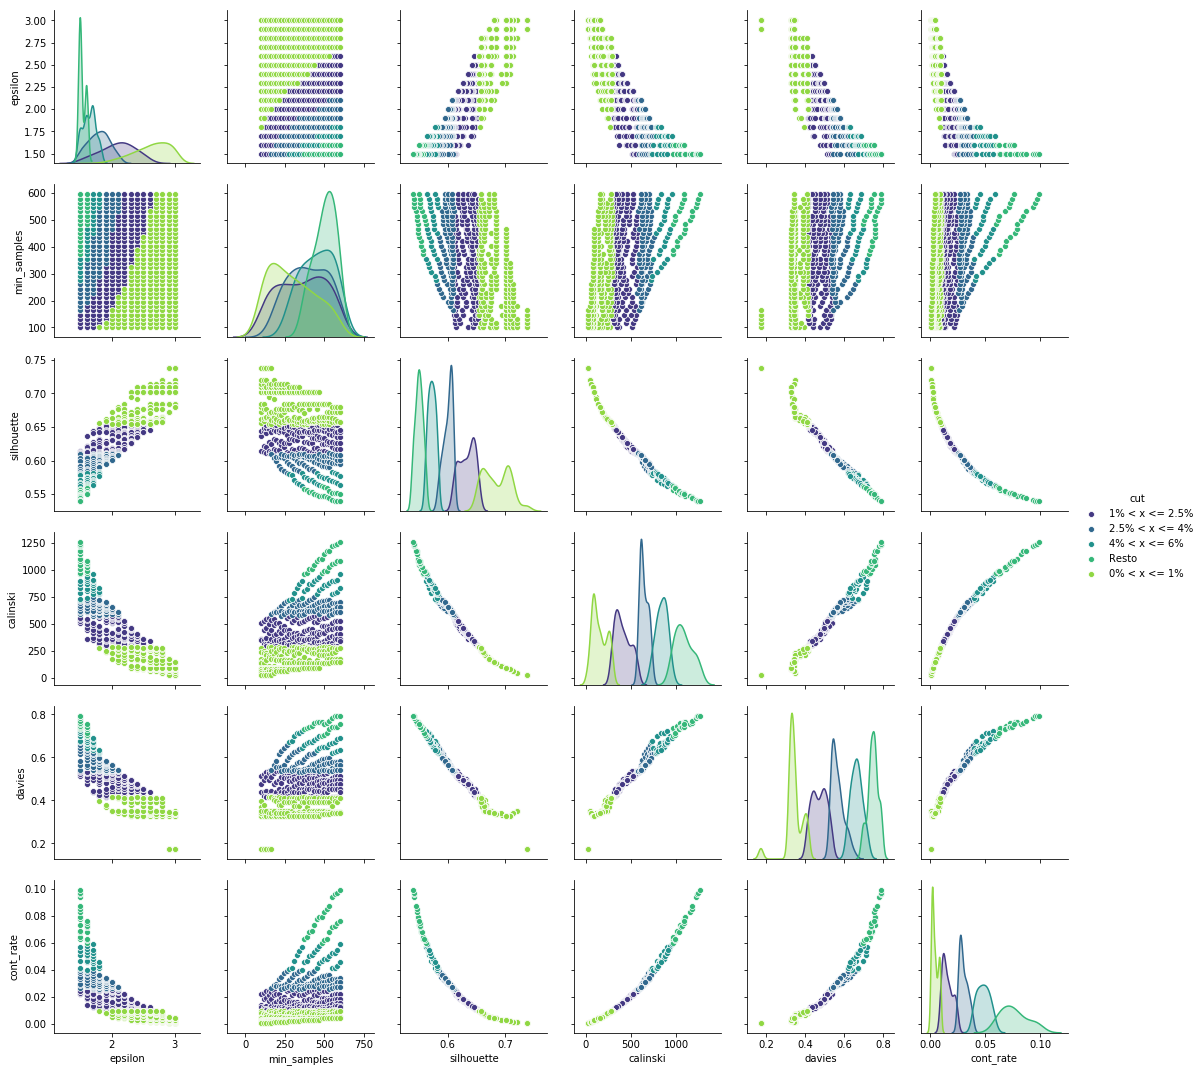

In [10]:
fig = sns.pairplot(output, hue='cut', palette='viridis')

Como vemos, a medida que a medida que aumentamos el parámetro _epsilon_, aumentamos el grado de separación intra clúster, lo cual nos interesa pues estamos definiendo mejor la frontera que delimita el hecho de pertenecer a una región anómala o no. Lo mismo sucede con el resto de métricas. Por otro lado, cabe decir que, si bien las métricas de evaluación mejoran, también disminuye el grado de contaminación del dataset. Esto es, disminuye el tanto por ciento de observaciones anómalas en nuestro dataset. Tendremos que encontrar un término medio. Consideramos que aquella selección de hiperparámetros que devuelve un grado de contaminación de entre el 1% y 2.5% es conveniente. 

In [11]:
sub = output[output['cut'].isin(['0% < x <= 1%', '1% < x <= 2.5%'])]
sub['cut'] = pd.cut(sub['cont_rate'], 5)
sub1 = sub.groupby('cut').mean()
epsilon = sub1.epsilon.values.tolist()
min_samples = sub1.min_samples.values.tolist()

/Users/nicolasforteza/Projects/venvs/generic/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


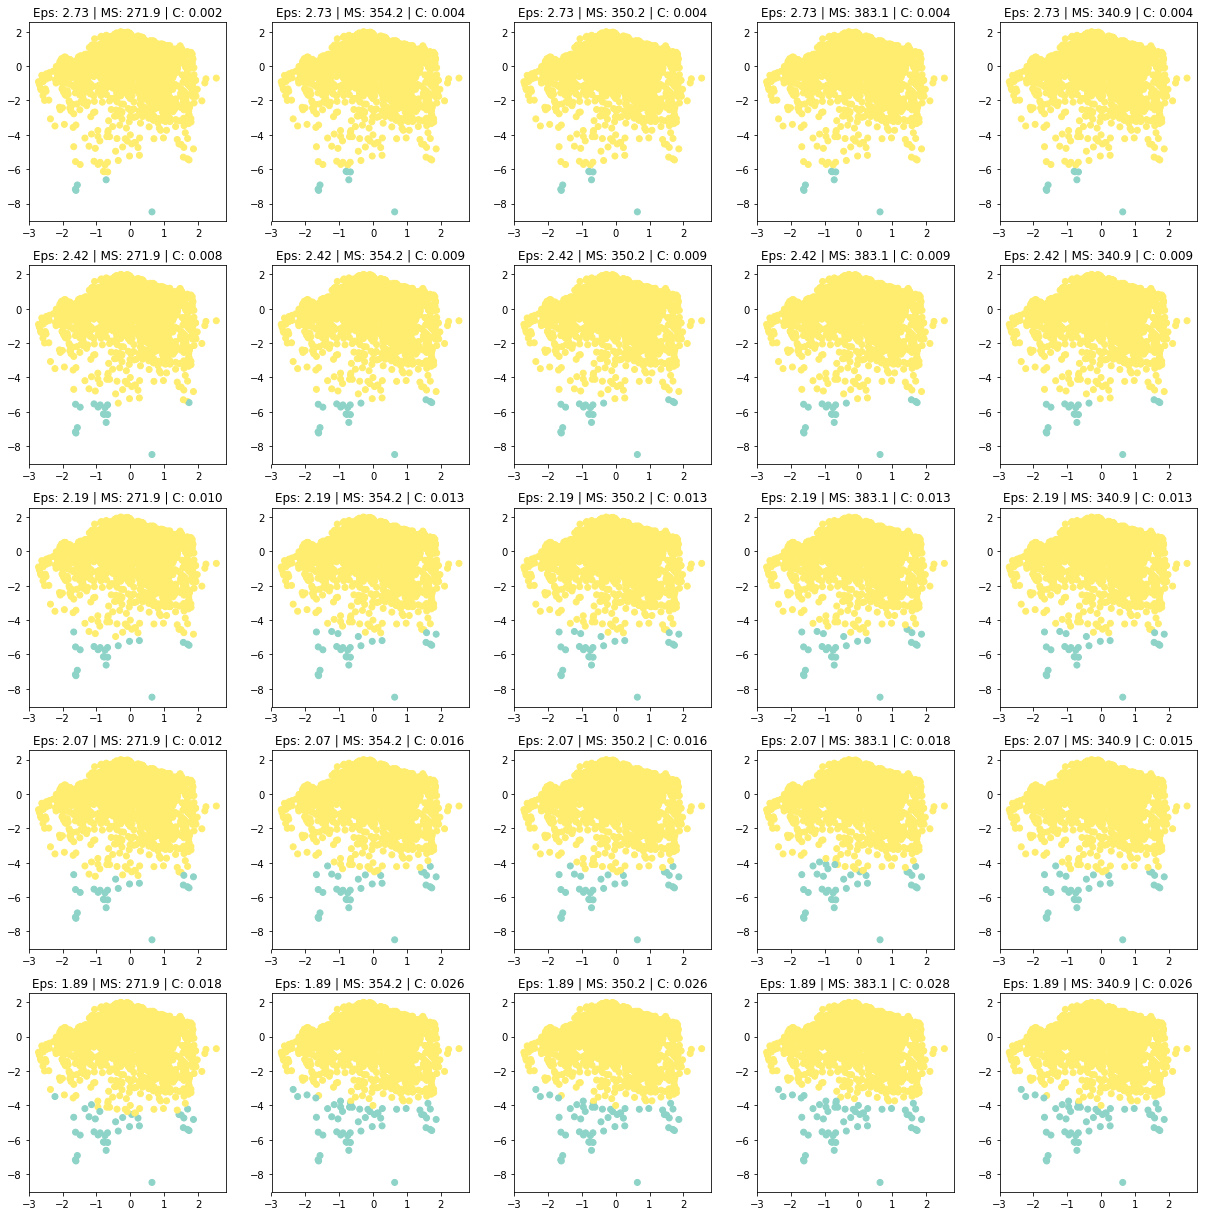

In [12]:
fig, ax = plt.subplots(len(epsilon), len(min_samples), figsize=(17, 17))

c_rate = 0
e = 0
m_s = 0

for eps in epsilon:
    for ms in min_samples:
        
        row = epsilon.index(eps)
        col = min_samples.index(ms)
        
        cluster = DBSCAN(eps=eps, min_samples=ms, metric='precomputed')
        cluster.fit(distances)
        
        cont = (np.sum(cluster.labels_ == -1) / aux.shape[0])
        if cont > c_rate:
            c_rate = cont
            e = eps
            m_s = ms
        
        ax[row, col].scatter(x=coordinates[:, 0], y=coordinates[:, 1], c=cluster.labels_, cmap='Set3')
        ax[row, col].set_title("Eps: {:.2f} | MS: {:.1f} | C: {:.3f}".format(eps, ms, cont))
        
plt.tight_layout()

Elegiremos aquellos hiperparámetros cercanos al 2.8% de contaminación de nuestro dataset. 

#### 4.2-. Isolation Forest.

Aplicamos aquí otro algoritmo de detección de anomalías, llamado Isolation Forest. Mediante el sampleo de subconjuntos de observaciones aleatorias, separa observaciones con un _ensemble_ de árboles de decisión, llamado _extra trees regressor_. La intuición es que cuando menos "frondoso" sea un árbol, más anómala será la observación pues habrá necesitado menos particiones para aislar a la observación. Más información sobre el algoritmo [aquí](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)

In [13]:
output = dict()
random_state = 0


for outliers_fraction in [0.01, 0.015, 0.02, 0.025, 0.03]:
    print("Fitting IF at {}".format(outliers_fraction))
    clf = IForest(contamination=outliers_fraction,
                                random_state=random_state)
    clf.fit(xx)
    scores = pd.DataFrame(data=clf.decision_scores_ , 
                          index=df.index, 
                          columns=['Anomaly Score'])
    threshold = clf.threshold_
    aux = df['y'].to_frame()
    results = pd.merge(aux, scores, left_index=True, right_index=True)
    results.index.freq = 'H'
    output['Isolation Forest {}'.format(outliers_fraction)] = {'results': results, 't': threshold}
    

Fitting IF at 0.01
Fitting IF at 0.015
Fitting IF at 0.02
Fitting IF at 0.025
Fitting IF at 0.03


In [14]:
from matplotlib.dates import DateFormatter
from matplotlib import dates

def plot_full_model(model):
    # create figure and axis
    fig = plt.figure(figsize=(17, 10))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2, rowspan=1)
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax3 = plt.subplot2grid((2, 2), (1, 1))

    # take the data
    data = output[model]
    # store the results for plot
    results = data['results']
    anomaly_score = data['results']['Anomaly Score']
    threshold = data['t']

    # ===== title ====
    title = "Threshold {:.2f}, Model: {}".format(threshold, model)
    fig.suptitle(title)
    sns.despine(bottom=False, left=True)

    # ===== main plot =====
    days = dates.MonthLocator()
    myFmt = DateFormatter("%m-%d")
    aux = results['Anomaly Score'].values
    plot1 = ax1.scatter(x=results.index, y=results['y'].values, 
                c=aux, cmap='viridis_r', alpha=0.6)
    ax1.xaxis.set_major_locator(days)
    ax1.xaxis.set_major_formatter(myFmt)
    ax1.grid(alpha=0.2)
    plt.colorbar(plot1, ax=ax1)


    # ==== hourly plot ====
    plot2 = sns.stripplot(anomaly_score.index.hour, anomaly_score, ax=ax2, palette='viridis')
    ax2.axhline(threshold, color='#f12e58', alpha=0.5)
    plot2.grid(alpha=0.2)

    # === weekly plot ==== 
    results['weekday'] = results.index.weekday
    plot3 = sns.stripplot(x='weekday', y='Anomaly Score',data=results, ax=ax3, palette='viridis')
    ax3.axhline(threshold, color='#f12e58', alpha=0.5)
    plot3.grid(alpha=0.2)

    # general configuration
    sns.despine(bottom=False, left=True)
    return fig

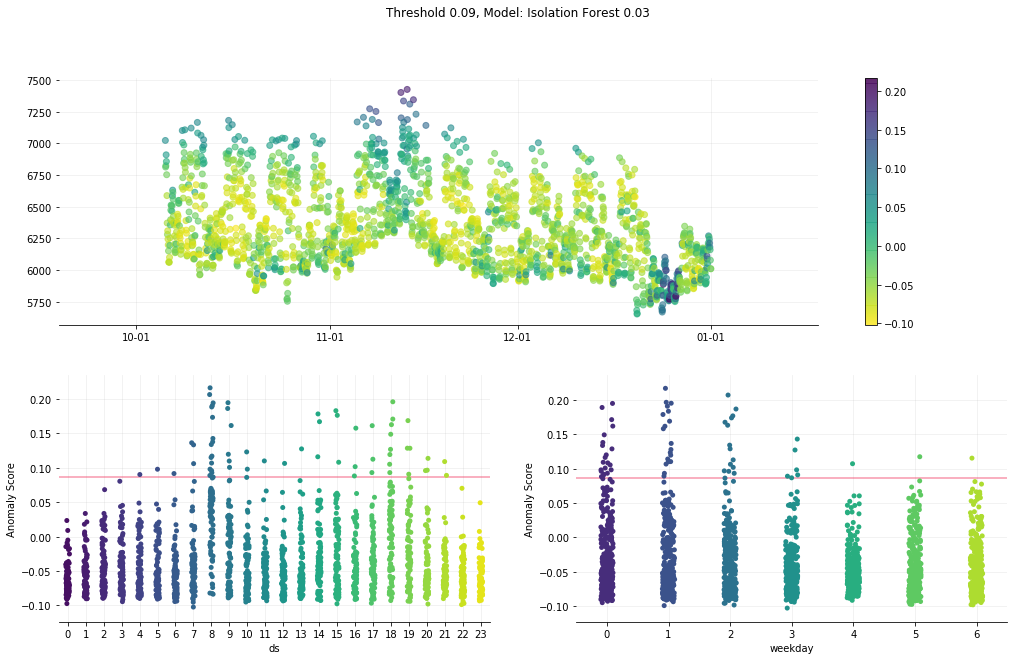

In [15]:
fig = plot_full_model('Isolation Forest 0.03')

Efectivamente, vemos cómo el Isolation Forest detecta anomalías en aquellas zonas con mayor variabilidad, dada nuestra matriz de _features_

#### 4.3-. _Ensemble_ de ambos modelos.

Si juntamos ambos modelos, podemos ver que llegamos a un alto grado de coincidencia entre ambos modelos. Calculamos el grado de coincidencia como la intersección del output en modo binario de ambos modelos.

In [16]:
fechas_if_mask = output['Isolation Forest 0.03']['results']['Anomaly Score'] > output['Isolation Forest 0.03']['t']
cluster = DBSCAN(eps=e, min_samples=m_s, metric='precomputed')
cluster.fit(distances)
fechas_dbscan_mask = cluster.labels_ == -1
intersection = set(df.index[fechas_if_mask]).intersection(set(df.index[fechas_dbscan_mask]))
coincidence_wrt_if = len(intersection) / len(df.index[fechas_if_mask])
coincidence_wrt_dbscan = len(intersection) / len(df.index[fechas_dbscan_mask])
print("Coincidencia media: {:.2f}%".format(np.mean([coincidence_wrt_if, coincidence_wrt_dbscan]) * 100))

Coincidencia media: 92.72%


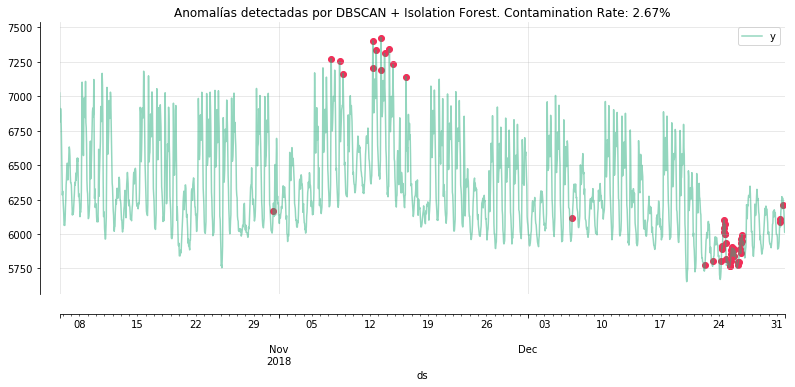

In [17]:
fig, ax = plt.subplots(figsize=(13, 5))
an = df.loc[intersection]
cr = an.shape[0] / df.shape[0]
df.plot(ax=ax, c='#29AF7FFF', alpha=0.5)
ax.scatter(x=an.index, y=an.values, c='#f12e58')
ax.grid(alpha=0.35)
ax.set_title("Anomalías detectadas por DBSCAN + Isolation Forest. Contamination Rate: {:.2f}%".format(cr * 100))
sns.despine(offset=20)